In [91]:
import os
from dotenv import load_dotenv
load_dotenv()


GROQ_API_KEY=os.getenv("GROQ_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY


In [92]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [93]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [94]:
llm.invoke("hi").content

'Hi! 👋  How can I help you today?\n'

In [95]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [96]:
multiply({"first_number":24,"second_number":364})

8736

In [97]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [98]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [99]:
search("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Current president\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\nFormer U.S. presidents\nThe United States has had 46 former U.S. presidents. Read about past presidents and vice presidents.\nMany former presidents have presidential libraries and museums you can visit to learn about their lives and their time in office. Find presidential libraries and museums.\nRequirements to be eligible to become president [...] Current first lady\nThe current first lady of the United States is Melania Trump.\nFormer first ladies\nFind a list of former first ladies and their presidential spouses.\nSee the Smithsonian Institution's virtual tour of first ladies' inaugural ball gowns and other artifacts.\nHow to contact the president, vice president, and first lady\nThe president, vice president, and fir

In [100]:
search.invoke("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Current president\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\nFormer U.S. presidents\nThe United States has had 46 former U.S. presidents. Read about past presidents and vice presidents.\nMany former presidents have presidential libraries and museums you can visit to learn about their lives and their time in office. Find presidential libraries and museums.\nRequirements to be eligible to become president [...] Current first lady\nThe current first lady of the United States is Melania Trump.\nFormer first ladies\nFind a list of former first ladies and their presidential spouses.\nSee the Smithsonian Institution's virtual tour of first ladies' inaugural ball gowns and other artifacts.\nHow to contact the president, vice president, and first lady\nThe president, vice president, and fir

In [101]:
tools=[search,multiply]

In [102]:
model_with_tools = llm.bind_tools(tools)

In [103]:
tool_mapping={tool.name: tool for tool in tools}

In [104]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002996C35D260>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002996C35CFE0>)}

In [105]:
response = model_with_tools.invoke("who is a current president of USA?")

In [106]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bns5', 'function': {'arguments': '{"query":"who is the current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.055792171, 'queue_time': 0.23327048699999997, 'total_time': 0.212155807}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a986331a-44a4-4445-b16c-ff3a3ac63976-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of USA'}, 'id': 'call_bns5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162})

In [107]:
tool_details=response.additional_kwargs.get("tool_calls")

In [108]:
tool_details

[{'id': 'call_bns5',
  'function': {'arguments': '{"query":"who is the current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [109]:
tool_details[0]["function"]["name"]

'search'

In [110]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of USA"}'

In [111]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is the current president of USA'}

In [112]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Current president\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\nFormer U.S. presidents\nThe United States has had 46 former U.S. presidents. Read about past presidents and vice presidents.\nMany former presidents have presidential libraries and museums you can visit to learn about their lives and their time in office. Find presidential libraries and museums.\nRequirements to be eligible to become president [...] Current first lady\nThe current first lady of the United States is Melania Trump.\nFormer first ladies\nFind a list of former first ladies and their presidential spouses.\nSee the Smithsonian Institution's virtual tour of first ladies' inaugural ball gowns and other artifacts.\nHow to contact the president, vice president, and first lady\nThe president, vice president, and fir

In [113]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [114]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [115]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [116]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [117]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [118]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [119]:
app = graph.compile()

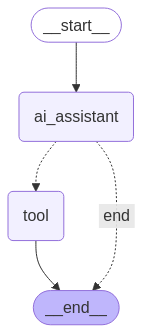

In [120]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [121]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_etmf', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1080, 'total_tokens': 1171, 'completion_time': 0.165454545, 'prompt_time': 0.037584166, 'queue_time': 0.23710946400000002, 'total_time': 0.203038711}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f3fa02f0-43fc-4161-ae26-06f0c8f2ba9e-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_etmf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 91, 'total_tokens': 1171})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [122]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [123]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
     

In [124]:
tavily=TavilySearchResults()

In [125]:
tools = [tavily]

In [126]:
llm_with_tools = llm.bind_tools(tools)

In [127]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [128]:
memory = MemorySaver()

In [129]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [130]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [131]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [132]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [133]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [134]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [135]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_q92t)
 Call ID: call_q92t
  Args:
    query: capital of india


In [136]:
snapshot = app2.get_state(config)

In [137]:
snapshot.next

('tools',)

In [138]:
last_message=snapshot.values["messages"][-1]

In [139]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q92t', 'function': {'arguments': '{"query":"capital of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 989, 'total_tokens': 1077, 'completion_time': 0.16, 'prompt_time': 0.057263689, 'queue_time': 0.31603468, 'total_time': 0.217263689}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4ac0a97e-3f05-4d69-9ad6-1f4b0e27e745-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of india'}, 'id': 'call_q92t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 88, 'total_tokens': 1077})

In [140]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'capital of india'},
  'id': 'call_q92t',
  'type': 'tool_call'}]

In [141]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [142]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_q92t)
 Call ID: call_q92t
  Args:
    query: capital of india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is the capital of India? States and union territories explained.", "url": "https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/", "content": "Want to learn more about the soon-to-be most populous country? Here’s some interesting information about how India is organized.\n\nWhat is the capital of India?\n\nThe capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River.\n\nCalcutta (now Kolkata, the capital of West Bengal) was the country’s capital until 1911 when King George V declared Delhi the new capital and construction of New Delhi began. [...] When the national government

In [143]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [144]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [145]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_f6r0)
 Call ID: call_f6r0
  Args:
    query: weather in new delhi


In [146]:
snapshot = app2.get_state(config)

In [147]:
snapshot.next

('tools',)

In [148]:
last_message=snapshot.values["messages"][-1]

In [149]:
last_message.tool_calls
     

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in new delhi'},
  'id': 'call_f6r0',
  'type': 'tool_call'}]

In [150]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [151]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_f6r0)
 Call ID: call_f6r0
  Args:
    query: weather in new delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "new delhi Weather Forecast 9 Apr 2025 - Times of India", "url": "https://timesofindia.indiatimes.com/weather/new-delhi-weather-forecast-today/110011", "content": "Today's Weather in New Delhi: In New Delhi today, the weather is expected to be Haze with a maximum temperature of 38°C and a minimum of 27°C. Sunrise in", "score": 0.9457263}, {"title": "Delhi - India weather forecast - Facebook", "url": "https://www.facebook.com/meteobox.delhi/photos/delhi-wednesday-09042025-weather-forecast-for-delhi-april-9-2025during-the-day-c/1243463754449967/", "content": "Delhi, Wednesday 09/04/2025: Weather forecast for Delhi April 9, 2025During the day cloudy. The highest temperature 